In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load the datasets
calls = pd.read_csv('callsf0d4f5a.csv')
customers = pd.read_csv('customers2afd6ea.csv')
reason = pd.read_csv('reason18315ff.csv')
sentiment = pd.read_csv('sentiment_statisticscc1e57a.csv')

In [2]:
# Merging datasets 
df = pd.merge(calls, customers, on='customer_id', how='left')
df = pd.merge(df, reason, on='call_id', how='left')
sentiment.drop('agent_id', axis=1, inplace=True)
df = pd.merge(df, sentiment, on='call_id', how='left')

In [3]:
df['call_start_datetime'] = pd.to_datetime(df['call_start_datetime'])
df['agent_assigned_datetime'] = pd.to_datetime(df['agent_assigned_datetime'])
df['call_end_datetime'] = pd.to_datetime(df['call_end_datetime'])

Calculating AHT and AST

In [4]:
# Calculate handle time in minutes
df['handle_time_minutes'] = (df['call_end_datetime'] - df['call_start_datetime']).dt.total_seconds() / 60

# Calculate AST: Average Speed to Answer (difference between when the call started and when it was picked up)
df['waiting_time_minutes'] = (df['agent_assigned_datetime'] - df['call_start_datetime']).dt.total_seconds() / 60

# Calculate AHT and AST for the entire dataset
aht = df['handle_time_minutes'].mean()
ast = df['waiting_time_minutes'].mean()

print(f"Overall AHT: {aht:.2f} minutes")
print(f"Overall AST: {ast:.2f} minutes")

Overall AHT: 18.90 minutes
Overall AST: 7.28 minutes


Explore Factors Contributing to Long AHT (Agent Performance, Call Reasons, Sentiment)

(a) Agent Performance

In [5]:
# Group by agent_id and calculate the average handle time for each agent
aht_by_agent = df.groupby('agent_id')['handle_time_minutes'].mean().sort_values(ascending=False)

# Identify agents with the longest average handle time
top_agents_longest_aht = aht_by_agent.head(10)
print(top_agents_longest_aht)

agent_id
102574    68.000000
506130    55.000000
140146    49.666667
255256    48.333333
558705    40.000000
136065    37.000000
336455    37.000000
780490    34.333333
384932    32.500000
906082    31.888889
Name: handle_time_minutes, dtype: float64


C:\Users\91873\AppData\Local\Temp\ipykernel_5732\619052468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_agents_longest_aht.index,y=top_agents_longest_aht.values ,palette="Greens_d")


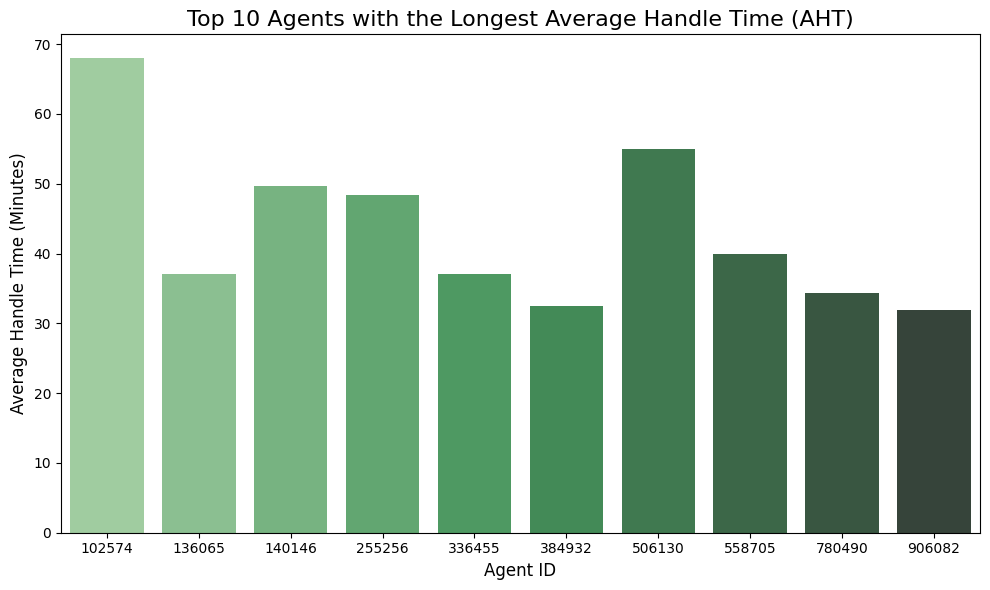

In [6]:
# Plot the top 10 agents with the longest AHT
plt.figure(figsize=(10, 6))
sns.barplot(x=top_agents_longest_aht.index,y=top_agents_longest_aht.values ,palette="Greens_d")
plt.title('Top 10 Agents with the Longest Average Handle Time (AHT)', fontsize=16)
plt.ylabel('Average Handle Time (Minutes)', fontsize=12)
plt.xlabel('Agent ID', fontsize=12)
plt.tight_layout()
plt.show()

(b) Call Type or Call Reasons


In [7]:
# Group by call reason to calculate average handle time (AHT)
aht_by_reason = df.groupby('primary_call_reason')['handle_time_minutes'].mean().sort_values(ascending=False)

# Identify the call reasons contributing to the longest average handle times
print("Top Call Reasons with Long AHT:")
print(aht_by_reason.head(10))

Top Call Reasons with Long AHT:
primary_call_reason
ETC               35.318182
Checkout          34.250000
Checkout          28.889674
Post Flight       25.782842
Post-Flight       25.272727
Post-Flight       24.961747
ETC               24.878495
Mileage  Plus     22.851852
Mileage Plus      22.615819
Mileage Plus      22.490000
Name: handle_time_minutes, dtype: float64


C:\Users\91873\AppData\Local\Temp\ipykernel_5732\117912879.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aht_by_reason.head(10).values, y=aht_by_reason.head(10).index, palette="Greens_d")


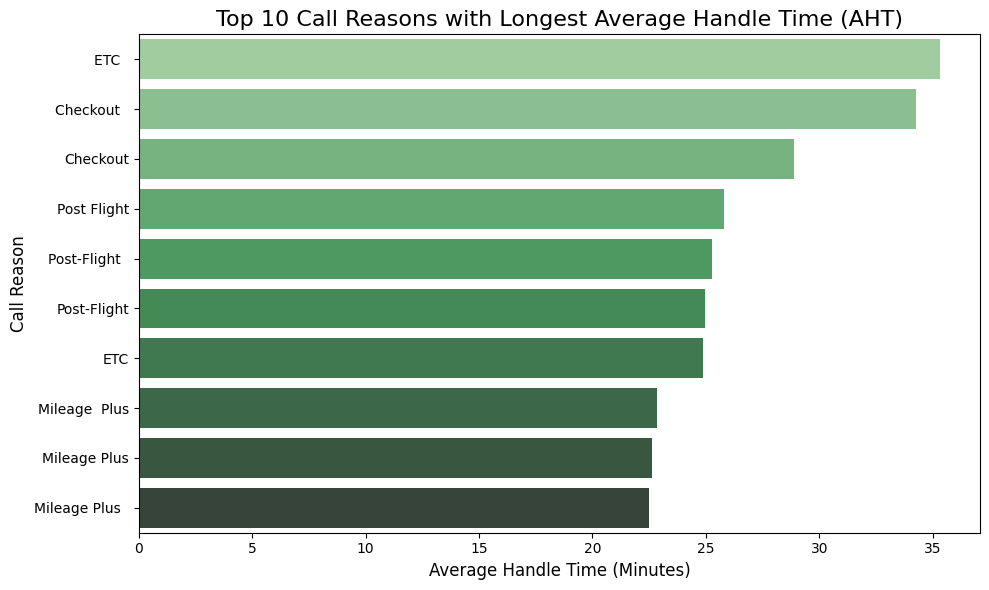

In [8]:
# Plot the top 10 call reasons with the longest AHT
plt.figure(figsize=(10, 6))
sns.barplot(x=aht_by_reason.head(10).values, y=aht_by_reason.head(10).index, palette="Greens_d")
plt.title('Top 10 Call Reasons with Longest Average Handle Time (AHT)', fontsize=16)
plt.xlabel('Average Handle Time (Minutes)', fontsize=12)
plt.ylabel('Call Reason', fontsize=12)
plt.tight_layout()
plt.show()

(c) Sentiment Analysis

In [9]:
# Group by sentiment and calculate average handle time
aht_by_sentiment = df.groupby('average_sentiment')['handle_time_minutes'].mean()

# Analyze how sentiment affects AHT
print(aht_by_sentiment)

average_sentiment
-1.38     9.000000
-1.25     9.000000
-1.22     6.000000
-1.19    11.000000
-1.17     4.000000
           ...    
 0.93    11.000000
 0.96    20.000000
 1.00     7.666667
 1.38     9.000000
 2.67    17.000000
Name: handle_time_minutes, Length: 183, dtype: float64


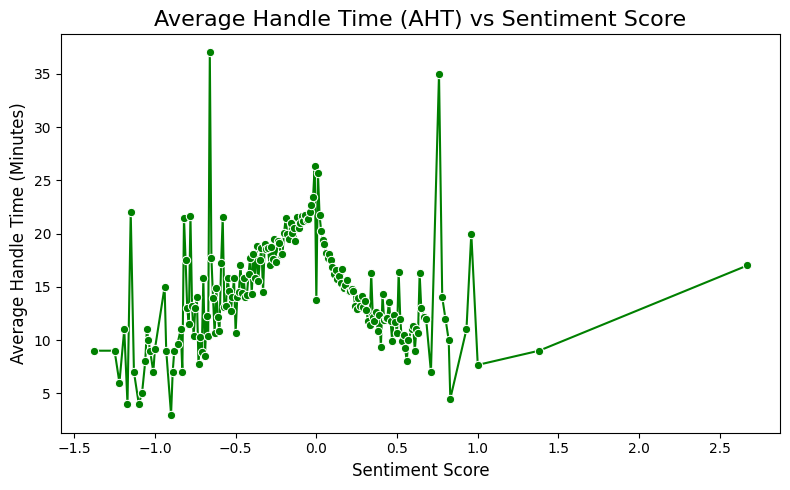

In [10]:
# Plot sentiment scores and their corresponding AHT
plt.figure(figsize=(8, 5))
sns.lineplot(x=aht_by_sentiment.index, y=aht_by_sentiment.values, marker='o', color='Green')
plt.title('Average Handle Time (AHT) vs Sentiment Score', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Average Handle Time (Minutes)', fontsize=12)
plt.tight_layout()
plt.show()

Identify Drivers of Long AHT and AST in High Volume Periods

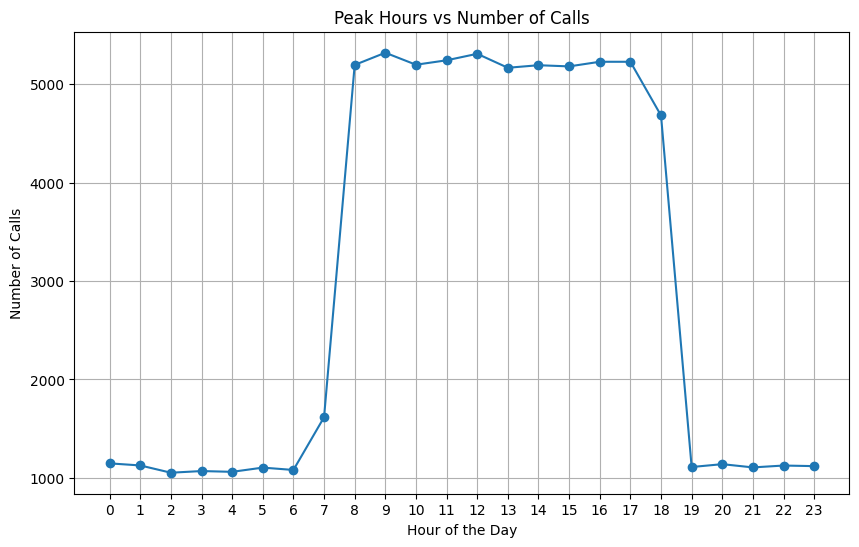

In [11]:
# Extract the hour from the call start time
df['hour'] = df['call_start_datetime'].dt.hour

# Count the number of calls for each hour
peak_hours = df['hour'].value_counts().sort_index()

# Display peak hours
plt.figure(figsize=(10, 6))
plt.plot(peak_hours.index, peak_hours.values, marker='o')
plt.title('Peak Hours vs Number of Calls')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-axis labels for 24 hours
plt.show()

AHT during peak hours: 18.91 minutes
AHT during non-peak hours: 18.88 minutes
AST during peak hours: 7.28 minutes
AST during non-peak hours: 7.29 minutes


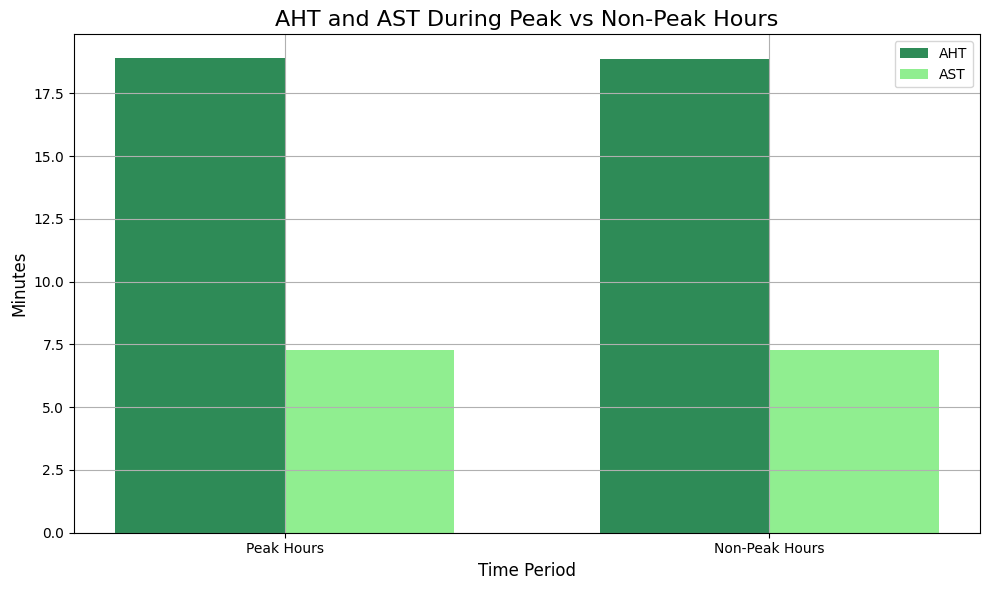

In [12]:
#Define peak hours (8 AM to 6 PM)
peak_hours = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
non_peak_hours = df[~((df['hour'] >= 8) & (df['hour'] <= 18))]

# Calculate AHT and AST during peak and non-peak hours
aht_peak_hours = peak_hours['handle_time_minutes'].mean()
ast_peak_hours = peak_hours['waiting_time_minutes'].mean()

aht_non_peak_hours = non_peak_hours['handle_time_minutes'].mean()
ast_non_peak_hours = non_peak_hours['waiting_time_minutes'].mean()

print(f"AHT during peak hours: {aht_peak_hours:.2f} minutes")
print(f"AHT during non-peak hours: {aht_non_peak_hours:.2f} minutes")

print(f"AST during peak hours: {ast_peak_hours:.2f} minutes")
print(f"AST during non-peak hours: {ast_non_peak_hours:.2f} minutes")

# Data for bar chart
time_periods = ['Peak Hours', 'Non-Peak Hours']
aht_values = [aht_peak_hours, aht_non_peak_hours]
ast_values = [ast_peak_hours, ast_non_peak_hours]

# Set width of bars
bar_width = 0.35
index = np.arange(len(time_periods))

# Plot grouped bar chart
plt.figure(figsize=(10, 6))

# Plot AHT bars
plt.bar(index, aht_values, bar_width, label='AHT', color='seagreen')

# Plot AST bars
plt.bar(index + bar_width, ast_values, bar_width, label='AST', color='lightgreen')

# Add labels and titles
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Minutes', fontsize=12)
plt.title('AHT and AST During Peak vs Non-Peak Hours', fontsize=16)

# Add xticks
plt.xticks(index + bar_width / 2, time_periods)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

Visualization of Percentage Difference Between AHT for Most and Least Frequent Call Reasons

Most Frequent Call Reason: IRROPS, AHT: 19.09 minutes
Least Frequent Call Reason: Unaccompanied Minor  , AHT: 15.00 minutes
Percentage Difference in AHT: 27.30%


C:\Users\91873\AppData\Local\Temp\ipykernel_5732\4195149816.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='AHT', data=reasons_data, palette='Greens_d')


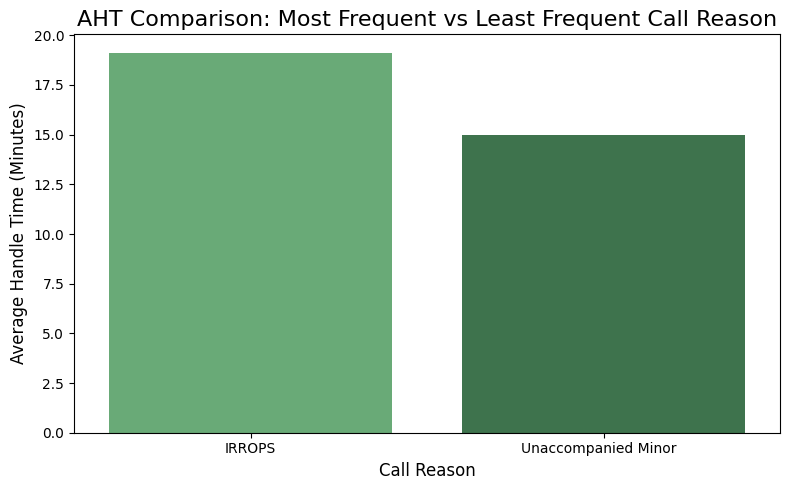

In [13]:
# Get the most frequent and least frequent call reasons
call_reason_counts = df['primary_call_reason'].value_counts()
most_frequent_reason = call_reason_counts.idxmax()
least_frequent_reason = call_reason_counts.idxmin()

# Calculate AHT for most and least frequent reasons
aht_most_frequent = aht_by_reason[most_frequent_reason]
aht_least_frequent = aht_by_reason[least_frequent_reason]

# Calculate percentage difference
percentage_difference = ((aht_most_frequent - aht_least_frequent) / aht_least_frequent) * 100

print(f"Most Frequent Call Reason: {most_frequent_reason}, AHT: {aht_most_frequent:.2f} minutes")
print(f"Least Frequent Call Reason: {least_frequent_reason}, AHT: {aht_least_frequent:.2f} minutes")
print(f"Percentage Difference in AHT: {percentage_difference:.2f}%")


# Plot to show percentage difference between AHT of most frequent and least frequent reasons
reasons_data = pd.DataFrame({
    'Reason': [most_frequent_reason, least_frequent_reason],
    'AHT': [aht_most_frequent, aht_least_frequent]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Reason', y='AHT', data=reasons_data, palette='Greens_d')
plt.title('AHT Comparison: Most Frequent vs Least Frequent Call Reason', fontsize=16)
plt.xlabel('Call Reason', fontsize=12)
plt.ylabel('Average Handle Time (Minutes)', fontsize=12)
plt.tight_layout()
plt.show()